# Segmentation using Graph Cuts

In [2]:
import cv2 as cv
import numpy as np
import maxflow
import matplotlib.pyplot as plt

In [ ]:
class GraphMaker:

    foreground = 1
    background = 0

    seeds = 0
    segmented = 1

    default = 0.5
    MAXIMUM = 1000000000

    def __init__(self):
        self.image = None
        self.graph = None
        self.overlay = None
        self.seed_overlay = None
        self.segment_overlay = None
        self.mask = None
        self.load_image('flower.png')
        self.background_seeds = []
        self.foreground_seeds = []
        self.background_average = np.array(3)
        self.foreground_average = np.array(3)
        self.nodes = []
        self.edges = []
        self.current_overlay = self.seeds

    def load_image(self, filename):
        self.image = cv.imread(filename)
        self.image = cv.cvtColor(self.image, cv.COLOR_BGR2RGB)
        self.graph = np.zeros_like(self.image)
        self.seed_overlay = np.zeros_like(self.image)
        self.segment_overlay = np.zeros_like(self.image)
        self.mask = None

    def add_seed(self, x, y, type):
        if self.image is None:
            print('Please load an image before adding seeds.')
        if type == self.background:
            if not self.background_seeds.__contains__((x, y)):
                self.background_seeds.append((x, y))
                cv.rectangle(self.seed_overlay, (x-1, y-1), (x+1, y+1), (0, 0, 255), -1)
        elif type == self.foreground:
            if not self.foreground_seeds.__contains__((x, y)):
                self.foreground_seeds.append((x, y))
                cv.rectangle(self.seed_overlay, (x-1, y-1), (x+1, y+1), (0, 255, 0), -1)

    def clear_seeds(self):
        self.background_seeds = []
        self.foreground_seeds = []
        self.seed_overlay = np.zeros_like(self.seed_overlay)

    def get_overlay(self):
        if self.current_overlay == self.seeds:
            return self.seed_overlay
        else:
            return self.segment_overlay

    def get_image_with_overlay(self, overlayNumber):
        if overlayNumber == self.seeds:
            return cv.addWeighted(self.image, 0.9, self.seed_overlay, 0.4, 0.1)
        else:
            return cv.addWeighted(self.image, 0.9, self.segment_overlay, 0.4, 0.1)

    def create_graph(self):
        if len(self.background_seeds) == 0 or len(self.foreground_seeds) == 0:
            print("Please enter at least one foreground and background seed.")
            return

        print("Making graph")
        print("Finding foreground and background averages")
        self.find_averages()

        print("Populating nodes and edges")
        self.populate_graph()

        print("Cutting graph")

        # STUFF WORKS TILL HERE 
        self.cut_graph()

    def find_averages(self):
        self.graph = np.zeros((self.image.shape[0], self.image.shape[1]))
        print(self.graph.shape)
        self.graph.fill(self.default)
        self.background_average = np.zeros(3)
        self.foreground_average = np.zeros(3)

        for coordinate in self.background_seeds:
            self.graph[coordinate[1] - 1, coordinate[0] - 1] = 0
            #self.background_average += self.image[coordinate[1], coordinate[0]]

        #self.background_average /= len(self.background_seeds)

        for coordinate in self.foreground_seeds:
            self.graph[coordinate[1] - 1, coordinate[0] - 1] = 1
            #self.foreground_average += self.image[coordinate[1], coordinate[0]]

        #self.foreground_average /= len(self.foreground_seeds)

    def populate_graph(self):
        self.nodes = []
        self.edges = []

        # make all s and t connections for the graph
        for (y, x), value in np.ndenumerate(self.graph):
            # this is a background pixel
            if value == 0.0:
                self.nodes.append((self.get_node_num(x, y, self.image.shape), self.MAXIMUM, 0))

            # this is a foreground node
            elif value == 1.0:
                self.nodes.append((self.get_node_num(x, y, self.image.shape), 0, self.MAXIMUM))

            else:
                '''d_f = np.power(self.image[y, x] - self.foreground_average, 2)
                d_b = np.power(self.image[y, x] - self.background_average, 2)
                d_f = np.sum(d_f)
                d_b = np.sum(d_b)
                e_f = d_f / (d_f + d_b)
                e_b = d_b / (d_f + d_b)'''
                self.nodes.append((self.get_node_num(x, y, self.image.shape), 0, 0))

                '''if e_f > e_b:
                    self.graph[y, x] = 1.0
                else:
                    self.graph[y, x] = 0.0'''

        for (y, x), value in np.ndenumerate(self.graph):
            if y == self.graph.shape[0] - 1 or x == self.graph.shape[1] - 1:
                continue
            my_index = self.get_node_num(x, y, self.image.shape)

            neighbor_index = self.get_node_num(x+1, y, self.image.shape)
            g = 1 / (1 + np.sum(np.power(self.image[y, x] - self.image[y, x+1], 2)))
            self.edges.append((my_index, neighbor_index, g))

            neighbor_index = self.get_node_num(x, y+1, self.image.shape)
            g = 1 / (1 + np.sum(np.power(self.image[y, x] - self.image[y+1, x], 2)))
            self.edges.append((my_index, neighbor_index, g))

    def cut_graph(self):
        self.segment_overlay = np.zeros_like(self.segment_overlay)
        self.mask = np.zeros_like(self.image, dtype=bool)
        g = maxflow.Graph[float](len(self.nodes), len(self.edges))
        nodelist = g.add_nodes(len(self.nodes))

        for node in self.nodes:
            g.add_tedge(nodelist[node[0]], node[1], node[2])

        for edge in self.edges:
            g.add_edge(edge[0], edge[1], edge[2], edge[2])

        flow = g.maxflow()

        for index in range(len(self.nodes)):
            if g.get_segment(index) == 1:
                xy = self.get_xy(index, self.image.shape)
                self.segment_overlay[xy[1], xy[0]] = (255, 0, 255)
                self.mask[xy[1], xy[0]] = (True, True, True)

    def swap_overlay(self, overlay_num):
        self.current_overlay = overlay_num

    def save_image(self, filename):
        if self.mask is None:
            print('Please segment the image before saving.')
            return

        to_save = np.zeros_like(self.image)

        np.copyto(to_save, self.image, where=self.mask)
        cv.imwrite(str(filename), to_save)

    @staticmethod
    def get_node_num(x, y, array_shape):
        return y * array_shape[1] + x

    @staticmethod
    def get_xy(nodenum, array_shape):
        return (nodenum % array_shape[1]), (nodenum / array_shape[1])

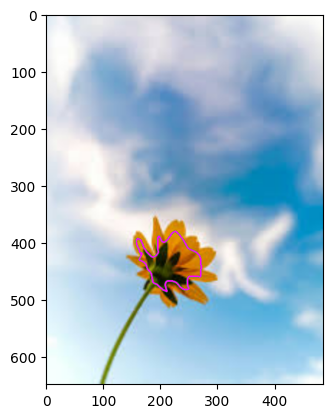

In [54]:
image = cv.imread('foreground.png')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
lower_green = np.array([0, 250, 0])
upper_green = np.array([10, 255, 10])
foreground_mask = cv.inRange(image, lower_green, upper_green)
image[foreground_mask > 0] = (255, 0, 255)
plt.imshow(image)

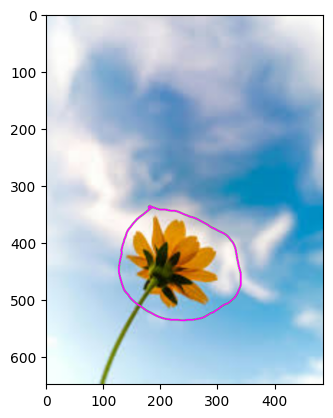

In [55]:
image = cv.imread('background.png')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
lower_green = np.array([0, 250, 0])
upper_green = np.array([10, 255, 10])
background_mask = cv.inRange(image, lower_green, upper_green)
image[background_mask > 0] = (255, 0, 255)
plt.imshow(image)

In [56]:
graphcut = GraphMaker()

In [ ]:
# go through the mask and add the seeds
for (y, x), value in np.ndenumerate(foreground_mask):
    if value == 255:
        graphcut.add_seed(x, y, GraphMaker.foreground)

In [58]:
for (y, x), value in np.ndenumerate(background_mask):
    if value == 255:
        graphcut.add_seed(x, y, GraphMaker.background)

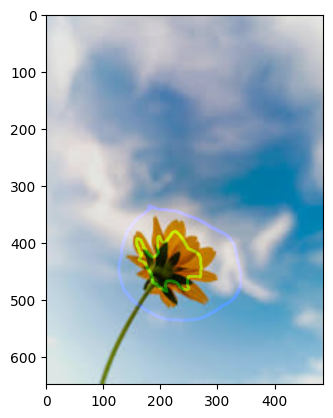

In [59]:
plt.imshow(graphcut.get_image_with_overlay(GraphMaker.seeds))

In [60]:
# create the graph
graphcut.create_graph()

Making graph
Finding foreground and background averages
(648, 486)
Populating nodes and edges
Cutting graph


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [65]:
len(graphcut.edges)

627590

In [70]:
# print the source and sink values
sources = 0
sinks = 0
for node in graphcut.nodes:
    if node[1] == 0:
        sources += 1
    if node[2] == 0:
        sinks += 1

print('Sources: ' + str(sources))
print('Sinks: ' + str(sinks))

Sources: 313062
Sinks: 313644


In [71]:
image.shape

(648, 486, 3)